In [1]:
## minimize total cost and maximize efficiency responding to a growing number of proximity stores

In [98]:
import pandas as pd

# Define the file path
file_path = 'MasterWorksheet(all data).xlsx' #Define your path to the masterfile
#file_path = '/content/drive/MyDrive/Erasmus/SCM - Group - Supply Chain Management/Assignment/MasterWorksheet(all data).xlsx'

# Load the Excel file into a DataFrame
all_orders = pd.read_excel(file_path, decimal=',')

# Now 'all_orders' contains the data from the Excel file

#all_orders.set_index('delivery date (d+1)', inplace =True)
all_orders['Fuel costs (€/km)'] = all_orders['Fuel costs (€/km)'].astype(float)
all_orders['Driver Costs (€/h)'] = all_orders['Driver Costs (€/h)'].astype(float)
all_orders['Vehicle Costs (€/day)'] = all_orders['Vehicle Costs (€/day)'].astype(float)
all_orders['Vehicle size limit'] = all_orders['Vehicle size limit'].str.replace(r'\D', '', regex=True).astype(int)
all_orders.sort_values(by='distance between DC and center of group [km]*')

c:\Users\coolg\Anaconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,delivery date (d+1),store,type,pallets,Type,Group,Vehicle size limit,distance between DC and center of group [km]*,average distance between stores [km],Pallet Capacity,Fuel costs (€/km),Driver Costs (€/h),Vehicle Costs (€/day)
727,07/may,3386,DRY GOODS,12,continente bom dia,6,33,30,30,33,0.5,11.0,110.0
611,03/may,3386,FRESH GOODS,8,continente bom dia,6,33,30,30,33,0.5,11.0,110.0
610,03/may,4508,FRESH GOODS,9,continente bom dia,6,33,30,30,33,0.5,11.0,110.0
609,03/may,5746,FRESH GOODS,10,continente bom dia,6,13,30,30,13,0.4,11.0,95.0
608,03/may,1902,FRESH GOODS,10,continente bom dia,6,13,30,30,13,0.4,11.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2269,04/may,3594,DRY GOODS,37,continente bom dia,10,33,285,50,33,0.5,11.0,110.0
2270,04/may,202,FRESH GOODS,34,continente,10,33,285,50,33,0.5,11.0,110.0
2271,04/may,1051,DRY GOODS,28,continente,10,33,285,50,33,0.5,11.0,110.0
2303,04/may,4327,FRESH GOODS,10,continente bom dia,10,33,285,50,33,0.5,11.0,110.0


In [3]:
#Make a list of all the days of the delivery week
delivery_days = all_orders['delivery date (d+1)'].unique()
delivery_days

array(['02/may', '03/may', '04/may', '05/may', '06/may', '07/may'],
      dtype=object)

This step-by-step explanation covers the main structure of the code for planning mixed deliveries of fresh and dry goods, based on their  location groups, and various constraints.  It's designed to iteratively plan deliveries until the total demand for each day is satisfied.

Initialize Plan and Loop Through Delivery Days:
Create an empty list called plan to store the delivery schedule for each day.
Use a loop to iterate through each day in the delivery_days.
Filter Orders for the Current Day:
Select orders from the dataframe (df) where the 'delivery date (d+1)' matches the current day.
Create an empty dataframe called deliveries to store the planned deliveries for the day.
Initialize a variable demand_satisfied to track the total demand satisfied.
Group Orders by Location Group:
Group the orders for the day by the 'Group' column to plan deliveries for each location group separately.
Iterate Through Location Groups:
Loop through each location group and plan deliveries for that group.
Calculate the total demand for fresh and dry goods for the current group.
Plan Deliveries for Dry Goods (between 17:00 and  19:00 or after all Fresh has been planned):
Iterate through orders for dry goods in the group.
Plan trips to satisfy dry goods demand, considering time constraints and capacity limits.
Calculate costs for each planned trip.
Plan Deliveries for Fresh Goods (after 19:00):
Iterate through orders for fresh goods in the group.
Plan trips to satisfy fresh goods demand, considering time constraints and capacity limits.
If we allow mixing, add dry goods from the same store, considering time constraints and capacity limits.
Calculate costs for each planned trip.
Update Remaining Demand:
Calculate how much fresh and dry goods demand remains after planning deliveries for the current group.
Repeat Until All Demand Satisfied:
Continue planning deliveries for different groups until the total demand for the day is satisfied.
Add Planned Deliveries to the Plan List:
Append the planned deliveries for the day to the plan list.
End of Loop:
Once deliveries are planned for all days, the loop ends


In [28]:
#Define Variables
Loading_docks = 40 #how many trucks can be filled at the same time
Dry_starttime = 17 #start hour for dry goods
Fresh_starttime = 19 #start hour for dry goods

Dry_limit_time = 48 #Dry goods have to be delivered within 48 hours
Fresh_limit_time = 32 #Fresh Goods have to be delivered before 8am on the second day

High_average_speed = 75 #km/h if travelling from the DC
Low_average_speed = 30 #km/h if not travelling from the DC

Average_loading_time = 15/60 #hours
added_loading_time_per_pallet = 80/60/60 #hours/pal
Average_unloading_time = 15/60 #hours
added_unloading_time_per_pallet = 120/60/60 #hours/pal


#function to check if orders to the same store and trip are separated by more than 3.5 hours
def check_order(deliveries, group_data, idx, start_time, good_type):
        #filter the current list of deliveries to only the matching good
        good_specific_deliveries = deliveries[deliveries['good_type'] == good_type].copy()
        
        # read each delivery's list of stores it will visit
        good_specific_deliveries['recieving_stores'] = good_specific_deliveries['recieving_stores'].apply(lambda x: list(map(int, x.strip('[]').split(','))) if isinstance(x, str) else [x])

        #find if the current delivery to plan has a matching store in any of the previous deliveries
        matching_delivery = good_specific_deliveries[good_specific_deliveries['recieving_stores'].apply(lambda x: group_data['store'].iat[idx] in x)]

        if not matching_delivery.empty: #if there was a delivery with the same good and store
            #if the matching delivery was more than 3.5 hours ago
            if start_time -  matching_delivery.iloc[0]['start_time'] > pd.to_timedelta(3.5, unit='H'):
                #notify me with the two start times and the difference!
                print("previous:", matching_delivery.iloc[0]['start_time'])
                print("current:", start_time)
                print("too late!", start_time - matching_delivery.iloc[0]['start_time'])          


In [92]:
def getPlan(drivers, mixing, group_order):
  
  Maximium_trip_time = 10*drivers #trip hour limit per driver
  
  #Make a dictionary for the truck costs, we can use this to calculate costs depending on the capacity of truck we use for each trip
  truck_costs = {
          13: {
              "Fuel_Costs": 0.40,
              "Driver_Costs": 11*drivers,
              "Vehicle_Costs": 95
          },
          24: {
              "Fuel_Costs": 0.45,
              "Driver_Costs": 11*drivers,
              "Vehicle_Costs": 110
          },
          33: {
              "Fuel_Costs": 0.50,
              "Driver_Costs": 11*drivers,
              "Vehicle_Costs": 110
          }
      }

       
  #plan is a list of each day and what deliveries are planned on that day
  plan = pd.DataFrame(columns=["day", "start_time", "loading_time", "v_capacity", "Pallets_in_vehicle", "good_type", "group", "Store_count","recieving_stores", "relative_pallets", "trip_duration", "return_time", "last_delivery_time","Dry_demand", "Fresh_demand", "reason_for_next", "Fuel_cost", "Driver_cost", "active_13trucks", "active_24trucks", "active_33trucks"])

  #make a loop, it repeats everything separately for each day and adds the schedule to plan
  for day in delivery_days:
    print(day)
    # Filter the DataFrame to select rows where 'delivery date (d+1)' matches the desired delivery day
    day_orders = all_orders[all_orders['delivery date (d+1)'] == day].copy()
    no = pd.to_datetime("2150") #no is a date value far in the future which is assigned to rows that are not partially satisfied (for sorting)
    yes = pd.to_datetime("2200") #yes is a date value far in the future which is assigned to rows that are fully satisfied (for sorting)
    day_orders['order_assigned'] = no #make a column with indication if the order is assigned to a truck [no, yes or a time when part of the order was picked up]
        #so when you sort the order list by order_assigned you get them in order partial, unassigned, assigned

    day = pd.to_datetime(day + " 2023") #convert the day value to a date number rather than the "may 01/2023" format 

    #create an empty table for all deliveries on that day, each row is one truck
    deliveries = pd.DataFrame(columns=["day", "start_time", "loading_time", "v_capacity", "Pallets_in_vehicle", "good_type", "group", "Store_count","recieving_stores", "relative_pallets", "trip_duration", "return_time", "last_delivery_time","Dry_demand", "Fresh_demand", "reason_for_next", "Fuel_cost", "Driver_cost", "active_13trucks", "active_24trucks", "active_33trucks"])
    #start the day with no deliveries planned (so no demand satisfied)
    demand_satisfied = 0

    #here we order the groups in which they will be planned
    if group_order == "close first": #we order the orders by distance of group from DC, so that we handle the nearest orders first 
      day_orders.sort_values(by='distance between DC and center of group [km]*', ascending=True, inplace=True)
    
    elif group_order == "far first": #we order the orders by distance of group from DC, so that we handle the furthest orders first 
      day_orders.sort_values(by='distance between DC and center of group [km]*', ascending=False, inplace=True)
    
    elif  group_order == "count up": #we order the orders by group number, so that we handle group 1's orders first 
      day_orders.sort_values(by='Group', ascending=True, inplace=True)
    
    elif  group_order == "random": #if interested in testing different group orders there is a random option too
      import random
      # Get unique group values
      unique_groups = day_orders['Group'].unique()
      # Shuffle the unique group values randomly
      random_order = random.sample(unique_groups.tolist(), len(unique_groups))
      # Apply the random order to the DataFrame
      day_orders['Group'] = day_orders['Group'].map(dict(zip(random_order, range(len(random_order)))))
      # Print the random order
      print("Random Order:", random_order)
      # Sort the DataFrame by the new order
      day_orders.sort_values(by='Group', ascending=True, inplace=True)

    # Group by the 'Group' column, to make a separate table for each location, we do this so that we plan each separately
    groups = []
    #makes a list of tables, one table for each group
    for group_name, group_data in day_orders.groupby('Group', sort=False):
      groups.append(group_data)

    delivery_count =  0 #no deliveries planned yet for this day
    start_time = day + pd.to_timedelta(Dry_starttime, unit='H') #set that start of planning to 17:00
    
    #sum how many fresh and dry goods pallets need to be delivered today
    Starting_fresh_demand = day_orders['pallets'][day_orders['type'] == "FRESH GOODS"].sum()
    Starting_dry_demand = day_orders['pallets'][day_orders['type'] == "DRY GOODS"].sum()
    total_day_demand = day_orders['pallets'].sum()

    #the fresh and dry_demand variables will be updated as we plan deliveries (demand will go down)
    Fresh_demand = Starting_fresh_demand
    Dry_demand = Starting_dry_demand

    #this loop below will repeat as long as all demand has not been satisfied
    while demand_satisfied < total_day_demand:
      
      # So here we check through each group at a time to plan deliveries
      for group_data in groups:
        group_name = group_data["Group"].iat[0] #set the current group we are checking


        #Calculate how much fresh and dry goods need to be assigned, this will change every time this loop is repeated
        Fresh_demand = group_data['pallets'][group_data['type'] == "FRESH GOODS"].sum()
        Dry_demand = group_data['pallets'][group_data['type'] == "DRY GOODS"].sum()

        #sort the group by dry first, then partial/unassigned orders and then ascending numbers of pallets, we use the first row of the table
        group_data.sort_values(by=['type', 'order_assigned', 'pallets'], ascending=[True, True, True], inplace=True)
        group_data.reset_index(drop=True, inplace=True) #since the order of rows has changed, this sets the row numbers back to 0, 1, 2, 3...(easier for code to know that row 0 is first row)

        #We will check if Dry demand needs to be satisfied in this group if the time is before 19:00 or no fresh demand remains
        #after 19:00, fresh demand needs to
        while Dry_demand > 0  and (Fresh_demand == 0 or start_time < day + pd.to_timedelta(Fresh_starttime, unit='H')):
          #this is where the planning of a trip starts
          if delivery_count+1 > Loading_docks: #all loading docks start empty so once they are all in use we have to wait until one is free
            start_time = deliveries["start_time"].iat[delivery_count-Loading_docks] + pd.to_timedelta(deliveries["loading_time"].iat[delivery_count+1-Loading_docks], unit='H')
            #start_time is either set to 17 or once a loading_time has passed of a previous row it is set to the time a dock frees up
          else: start_time = day + pd.to_timedelta(Dry_starttime, unit='H')

          if start_time >= day + pd.to_timedelta(Fresh_starttime, unit='H') and Fresh_demand != 0:
            reason_for_next = "19:00 threshold"
            break

          Pallets_in_vehicle = 0 #set value to count how may pallets have been assigned to the vehicle
          delivery_count += 1 #start a new delivery += adds to the current value 1
          recieving_stores = [] #a list of the stores this truck will go to
          relative_pallets = [] #a list of the pallets per store (in order)

          v_capacity = group_data['Vehicle size limit'].iat[0]  #set the current delivery capacity limit to the first value in the orders table

          Store_count = 1 #count the number of stores to be visited

          #while loop to add goods to a truck, repeats until we can't add more to it (various reasons)
          while Pallets_in_vehicle < v_capacity: #is there still space in the truck?
            
            #need to check if adding pallets from the next row will change the size limit and then be too much
            if group_data['Vehicle size limit'].iat[0] < Pallets_in_vehicle:
              reason_for_next = "can't add more pallets due to size limit"
              Store_count -= 1 #we thought we could add another store after the last loop, but nvm, no space
              break #finish adding to truck and go to calculation of distance and costs of delivery
            added  = True #assume we will add pallets to this trip

            #Check if the current order is partially assigned, then calculate how long it has been waiting
            if group_data['order_assigned'].iat[0] < no: #less than no is any date and time earlier than 2150 (we set that vanlue for no), meaning it was partly planned at that time
              #check if any partial orders are being completed too late
              check_order(deliveries, group_data, 0, start_time, "DRY")

            #check if the store has ordered more than the truck can still hold, and that it's not too late to take part of an order (we don't want half orders to wait more than 4 hours)
            if group_data['pallets'].iat[0] > min(group_data['Vehicle size limit'].iat[0], v_capacity) - Pallets_in_vehicle and (start_time < day + pd.to_timedelta(18.3, unit='H') or start_time > day + pd.to_timedelta(19, unit='H')):
              #take the order volume the truck can still hold
              v_capacity = min(group_data['Vehicle size limit'].iat[0], v_capacity)  #update delivery capacity limit with the current store, capacity can only go down
              group_data['pallets'].iat[0] -= v_capacity - Pallets_in_vehicle #remove from order row, some goods still remain
              recieving_stores.append(group_data['store'].iat[0]) #add the current store number to the list (row 0 is first row)
              relative_pallets.append(v_capacity - Pallets_in_vehicle) #note the number of pallets for this store 
              Pallets_in_vehicle += v_capacity - Pallets_in_vehicle #add to the vehicle (fill)
              group_data['order_assigned'].iat[0] = start_time #a partial order has been created at this start time
              
            
            #if there is enough space to hold the whole order, we can add it 
            elif group_data['pallets'].iat[0] <= min(group_data['Vehicle size limit'].iat[0], v_capacity) - Pallets_in_vehicle:#if the truck can hold the whole order
              v_capacity = min(group_data['Vehicle size limit'].iat[0], v_capacity)  #update delivery capacity limit with the current store, capacity can only go down
              Pallets_in_vehicle += group_data['pallets'].iat[0] #add to the truck
              recieving_stores.append(group_data['store'].iat[0]) #add the current store number to the list (row 0 is first row)
              relative_pallets.append(group_data['pallets'].iat[0]) #note the number of pallets for this store 
              group_data['pallets'].iat[0] = 0 #order of first row is satisfied
              group_data['order_assigned'].iat[0] = yes #this order is fully assigned 

              #sort the group by dry first, then partial/unassigned orders and then ascending numbers of pallets, we use the first row of the table
              group_data.sort_values(by=['type', 'order_assigned', 'pallets'], ascending=[True, True, True], inplace=True)
              group_data.reset_index(drop=True, inplace=True) #since the order of rows has changed, this sets the row numbers back to 0, 1, 2, 3...(easier for code to know that row 0 is first row)
            
            #If there's not enough space for the whole order and it's too close to 19:00 add half, we add nothing 
            else: 
              Store_count -= 1 #we cancel adding this store's pallets because it's too late to add half an order
              added = False #indicate that nothing was added from this order
              
            #Calculate how many dry goods still need to be assigned in the current group
            Dry_demand = group_data['pallets'][group_data['type'] == "DRY GOODS"].sum()

            #calculate how long it would take to fill the truck
            loading_time = Average_loading_time + Pallets_in_vehicle * added_loading_time_per_pallet
            #calculate how long the entire trip will take
            trip_duration = loading_time + Pallets_in_vehicle * added_unloading_time_per_pallet + group_data["distance between DC and center of group [km]*"].iat[0] *2 / High_average_speed + group_data["average distance between stores [km]"].iat[0] * (Store_count-1) / Low_average_speed
            #calculate what time the driver completes the final delivery of their trip
            last_delivery_time = start_time +  pd.to_timedelta(trip_duration - group_data["distance between DC and center of group [km]*"].iat[0] / High_average_speed, unit='H')
            return_time = start_time + pd.to_timedelta(trip_duration, unit='H')  #and the time they arrive back at Sonae

            if Dry_demand == 0:#if there is no more dry demand then there is nothing left to add to the truck
              reason_for_next = "dry demand satisfied" #define why we stop filling
              break #stop filling this truck and leave the current loop to calculate trip costs

            #check if there is still space in the truck and if adding more would make the trip too long
            if Pallets_in_vehicle < v_capacity and trip_duration + group_data["average distance between stores [km]"].iat[0] / Low_average_speed + min((v_capacity - Pallets_in_vehicle),group_data['pallets'].iat[0]) * (added_unloading_time_per_pallet + added_loading_time_per_pallet) <= Maximium_trip_time: 
              Store_count += 1 #We should be able to deliver to another store, so add one to the value

            #check if adding another store would make the trip too long
            if trip_duration + group_data["average distance between stores [km]"].iat[0] / Low_average_speed + min((v_capacity - Pallets_in_vehicle),group_data['pallets'].iat[0])  * (added_unloading_time_per_pallet + added_loading_time_per_pallet) > Maximium_trip_time:
              reason_for_next = "long trip" #define why we stop adding to this truck
              break #stop filling this truck and leave the current loop to calculate trip costs

            #check if adding another store would make the last delivery too late (deadline)
            if last_delivery_time + pd.to_timedelta(group_data["average distance between stores [km]"].iat[0] / Low_average_speed + min((v_capacity - Pallets_in_vehicle),group_data['pallets'].iat[0])  * (added_unloading_time_per_pallet + added_loading_time_per_pallet), unit='H') > day + pd.to_timedelta(Dry_limit_time, unit='H') :
              reason_for_next = "Adds too much time for dry trip limit" #define why we stopp adding to this truck
              break #stop filling this truck and leave the current loop to calculate trip costs
            
            if added == False: #nothing was added to the truck this loop 
              reason_for_next = "too late to create partial dry trip" #adding part of the top order to this truck would make it wait too long for the second part
              break #so we can stop adding to this truck
            reason_for_next = "full vehicle" #if all other checks have passed, the only remaining reason we stop filling a truck is because it's full
          
          if Pallets_in_vehicle > 0: #if there are any pallets added to this truck we can calculate costs
            #Calculate costs
            Fuel_cost = (group_data["distance between DC and center of group [km]*"].iat[0] * 2 + group_data["average distance between stores [km]"].iat[0] * (Store_count-1)) * truck_costs[v_capacity]["Fuel_Costs"]
            #if the trip takes less than an hour we only need 1 driver, if its more we pay for 2 drivers
            if trip_duration <= 10: Driver_cost = trip_duration * truck_costs[v_capacity]["Driver_Costs"]/drivers
            else: Driver_cost = trip_duration * truck_costs[v_capacity]["Driver_Costs"]


            # Define the data for the new row, "this is the column name" and to the right of those are the values for the row/column
            new_row_data = {"day": day, "start_time": start_time, "loading_time": loading_time, "v_capacity": v_capacity, "Pallets_in_vehicle": Pallets_in_vehicle, "good_type": "DRY", "group": group_name, "Store_count": Store_count,
                "recieving_stores": str(recieving_stores), "relative_pallets": str(relative_pallets), "trip_duration": trip_duration, "return_time": return_time, "last_delivery_time": last_delivery_time, "Dry_demand": Dry_demand,
                "Fresh_demand": Fresh_demand, "reason_for_next": reason_for_next, "Fuel_cost": Fuel_cost, "Driver_cost": Driver_cost,
            }

            # Create a new DataFrame row with the specified index and data
            new_row = pd.DataFrame(data=new_row_data, index=[delivery_count])

            # Concatenate the new row with the existing 'deliveries' DataFrame
            deliveries = pd.concat([deliveries, new_row])
          else: #if we did not manage to add pallets to this vehicle
            delivery_count -= 1 #subtract a delivery because no pallets could be assigned 
            #it probably means its ready to wait for fresh orders to be ready, set start_time to 19:00
            start_time = day +  pd.to_timedelta(Fresh_starttime, unit='H') +  pd.to_timedelta(1, unit='m')  

        #calculate the number of planned pallets we have  
        demand_satisfied = deliveries["Pallets_in_vehicle"].sum()
        
        #if we have not been able to add partial orders due to it being too close to 19:00, past 19:00 or dry demand is fully planned before 19:00
        if reason_for_next == "too late to create partial dry trip" or reason_for_next == "19:00 threshold" or reason_for_next == "dry demand satisfied": 
          reason_for_next = "moving to fresh" #next time we come to this line of code we move past, to fresh demand planning
          break #restart the for groups loop back to the first group in the list

        #sort the group by Fresh first, then partial/unassigned orders and then ascending numbers of pallets, we use the first row of the table
        group_data.sort_values(by=['type', 'order_assigned', 'pallets'], ascending=[False, True, True], inplace=True)
        group_data.reset_index(drop=True, inplace=True) #since the order of rows has changed, this sets the row numbers back to 0, 1, 2, 3...(easier for code to know that row 0 is first row)

        #Calculate how much fresh goods need to be assigned
        Fresh_demand = group_data['pallets'][group_data['type'] == "FRESH GOODS"].sum()

        #Check if more fresh demand needs to be satisfied in this group and if it's 19:00 or later
        while Fresh_demand > 0 and start_time >= day + pd.to_timedelta(Fresh_starttime, unit='H'):#everything in this loop is for one truck at a time and it repeats for the next truck
          #this is where the planning of a trip starts
          if delivery_count+1 > Loading_docks: #all loading docks start empty so once they are all in use we have to wait until one is free
            start_time = max(day + pd.to_timedelta(Fresh_starttime, unit='H') ,deliveries["start_time"].iat[delivery_count-Loading_docks] + pd.to_timedelta(deliveries["loading_time"].iat[delivery_count+1-Loading_docks], unit='H') )
            #start_time is either set to 19 or once a loading_time has passed of a previous row it is set to the time a dock frees up
          else: start_time = day + pd.to_timedelta(Fresh_starttime, unit='H') #this only happens if there was not enough dry demand to use up 40 loading docks
          if start_time < day + pd.to_timedelta(Fresh_starttime, unit='H'): break #so we exit this fresh demand while loop, nothing below here happens and we eventually come back to the loops above

          Pallets_in_vehicle = 0 #set value to count how may pallets have been assigned to the vehicle
          delivery_count += 1 #start a new delivery += adds to the current value 1
          recieving_stores = [] #a list of the stores this truck will go to
          relative_pallets = []  #a list of the pallets per store (in order)
                        
          type ="FRESH" #the type of good we are planning in this loop
          v_capacity = group_data['Vehicle size limit'].iat[0]  #set the current delivery capacity limit to the first value in the orders table

          Store_count = 1 #count the number of stores to be visited


          #while loop to add goods to a truck, repeats until we can't add more to it (various reasons)
          while Pallets_in_vehicle < v_capacity: #is there still space in the truck?
            #need to check if adding pallets from the next row will change the size limit and then be too much
            if group_data['Vehicle size limit'].iat[0] < Pallets_in_vehicle:
              reason_for_next = "can't add more pallets due to size limit change"
              Store_count -= 1 #we thought we could add another store after the last loop, but nvm, no space
              break #finish adding to truck and go to calculation of distance and costs of delivery

            #Check if the current order is partially assigned, then calculate how long it has been waiting
            if group_data['order_assigned'].iat[0] < no: #less than no is any date and time earlier than 2150 (we set that vanlue for no), meaning it was partly planned at that time
              #check if any partial orders are being completed too late
              check_order(deliveries, group_data, 0, start_time, "FRESH")
              check_order(deliveries, group_data, 0, start_time, "FRESH and DRY")

            v_capacity = min(group_data['Vehicle size limit'].iat[0], v_capacity)  #update delivery capacity limit with the current store, capacity can only go down

            #check if the store has ordered more than the truck can still hold
            if group_data['pallets'].iat[0] > v_capacity - Pallets_in_vehicle:
              #take the order volume the truck can still hold
              recieving_stores.append(group_data['store'].iat[0]) #add the current store number to the list (row 0 is first row)
              relative_pallets.append(v_capacity - Pallets_in_vehicle) #note the number of pallets for this store 
              
              group_data['pallets'].iat[0] -= v_capacity - Pallets_in_vehicle #remove from order row, some goods still remain
              Pallets_in_vehicle += v_capacity - Pallets_in_vehicle #add to the vehicle (fill)
              group_data['order_assigned'].iat[0] = start_time #we took part of an order, note down the starting time

            else:#if the truck can hold the whole order
              Pallets_in_vehicle += group_data['pallets'].iat[0] #add to the truck
              
              recieving_stores.append(group_data['store'].iat[0]) #add the current store number to the list (row 0 is first row)
              relative_pallets.append(group_data['pallets'].iat[0]) #note the number of pallets for this store 
              
              group_data['pallets'].iat[0] = 0 #order of first row is satisfied
              group_data['order_assigned'].iat[0] = yes #the whole order is planned
              
              
              if mixing: #if we allow mixing of dry and fresh we can add the dry from the same store to this truck
                #check in the current group if there is an order for dry goods from the same store
                dry_order_same_store = group_data[(group_data['store'] == group_data['store'].iat[0]) & (group_data['type'] == "DRY GOODS") & (group_data['pallets'] > 0)]
                
                if len(dry_order_same_store) > 0: #if there are orders from the same store
                  row = dry_order_same_store.index #set a row number that has that store in the group table
                  
                  #calculate how long it would currently take to fill the truck
                  loading_time = Average_loading_time + Pallets_in_vehicle * added_loading_time_per_pallet
                  #calculate how long the entire trip will currently take
                  trip_duration = loading_time + Pallets_in_vehicle * added_unloading_time_per_pallet + group_data["distance between DC and center of group [km]*"].iat[0] *2 / High_average_speed + group_data["average distance between stores [km]"].iat[0] * (Store_count-1) / Low_average_speed
                  #calculate what time the driver completes the final delivery of their trip
                  last_delivery_time = start_time + pd.to_timedelta(trip_duration - group_data["distance between DC and center of group [km]*"].iat[0] / High_average_speed, unit='H')
                  return_time = start_time + pd.to_timedelta(trip_duration, unit='H') #and the time they arrive back at Sonae
                  
                  #check if adding dry goods would make the last delivery too late (deadline)
                  if v_capacity > Pallets_in_vehicle and last_delivery_time + pd.to_timedelta(min((v_capacity - Pallets_in_vehicle), group_data['pallets'].iat[row[0]] )  * (added_unloading_time_per_pallet + added_loading_time_per_pallet), unit='H') < day + pd.to_timedelta(Fresh_limit_time, unit='H'):
                    type ="FRESH and DRY" #we can mix and add from that order too
                    
                    #Check if the current order is partially assigned, then calculate how long it has been waiting
                    if group_data['order_assigned'].iat[row[0]] < no: #less than no is any date and time earlier than 2150 (we set that vanlue for no), meaning it was partly planned at that time
                      #check if any partial orders are being completed too late
                      check_order(deliveries, group_data, row[0], start_time, "DRY")
                      check_order(deliveries, group_data, row[0], start_time, "FRESH and DRY")

                    #check if the truck can only hold part of the order
                    if group_data['pallets'].iat[row[0]] > v_capacity - Pallets_in_vehicle:
                      relative_pallets.append(f"dry:{v_capacity - Pallets_in_vehicle}") #note the number of dry pallets for this store
                      group_data['pallets'].iat[row[0]] -= v_capacity - Pallets_in_vehicle #remove from order row, some goods still remain
                      Pallets_in_vehicle += v_capacity - Pallets_in_vehicle #add to the vehicle (fill)
                      group_data['order_assigned'].iat[row[0]] = start_time #we took part of an order, note down the starting time

                    else:#if the truck can hold the whole order
                      Pallets_in_vehicle += group_data['pallets'].iat[row[0]] #add to the truck
                      relative_pallets.append(f"dry:{group_data['pallets'].iat[row[0]]}") #note the number of dry pallets for this store
                      group_data['pallets'].iat[row[0]] = 0 #order of the row is satisfied
                      group_data['order_assigned'].iat[row[0]] = yes #entire order has been satisfied

              #sort the group by Fresh first, then partial/unassigned orders and then ascending numbers of pallets, we use the first row of the table
              group_data.sort_values(by=['type', 'order_assigned', 'pallets'], ascending=[False, True, True], inplace=True)
              group_data.reset_index(drop=True, inplace=True) #since the order of rows has changed, this sets the row numbers back to 0, 1, 2, 3...(easier for code to know that row 0 is first row)

            #Calculate how much fresh goods still need to be assigned
            Fresh_demand = group_data['pallets'][group_data['type'] == "FRESH GOODS"].sum()

            #calculate how long it would take to fill the truck
            loading_time = Average_loading_time + Pallets_in_vehicle * added_loading_time_per_pallet
            #calculate how long the entire trip will take
            trip_duration = loading_time + Pallets_in_vehicle * added_unloading_time_per_pallet + group_data["distance between DC and center of group [km]*"].iat[0] *2 / High_average_speed + group_data["average distance between stores [km]"].iat[0] * (Store_count-1) / Low_average_speed
            #calculate what time the driver completes the final delivery of their trip
            last_delivery_time = start_time + pd.to_timedelta(trip_duration - group_data["distance between DC and center of group [km]*"].iat[0] / High_average_speed, unit='H')
            return_time = start_time + pd.to_timedelta(trip_duration, unit='H') #and the time they arrive back at Sonae

            if Fresh_demand == 0:#if there is no more fresh demand then there is nothing left to add to the truck
              reason_for_next = "demand satisfied" #define why we stop filling
              break #stop filling this truck and leave the current loop to calculate trip costs

            #check if there is still space in the truck and if adding more would make the trip too long
            if Pallets_in_vehicle < v_capacity and trip_duration + group_data["average distance between stores [km]"].iat[0] / Low_average_speed + min((v_capacity - Pallets_in_vehicle),group_data['pallets'].iat[0]) * (added_unloading_time_per_pallet + added_loading_time_per_pallet) <= Maximium_trip_time:
              Store_count += 1 #We should be able to deliver to another store, so add one to the value

            #check if adding another store would make the trip too long
            if trip_duration + group_data["average distance between stores [km]"].iat[0] / Low_average_speed + min((v_capacity - Pallets_in_vehicle),group_data['pallets'].iat[0])  * (added_unloading_time_per_pallet + added_loading_time_per_pallet) > Maximium_trip_time:
              reason_for_next = "long trip" #define why we stopp adding to this truck
              break #stop filling this truck and leave the current loop to calculate trip costs

            #check if adding another store would make the last delivery too late (deadline)
            if last_delivery_time + pd.to_timedelta(group_data["average distance between stores [km]"].iat[0] / Low_average_speed + min((v_capacity - Pallets_in_vehicle),group_data['pallets'].iat[0])  * (added_unloading_time_per_pallet + added_loading_time_per_pallet), unit='H') > day + pd.to_timedelta(Fresh_limit_time, unit='H'):
              reason_for_next = "too late for fresh trip" #define why we stop adding to this truck
              break #stop filling this truck and leave the current loop to calculate trip costs

            reason_for_next = "full vehicle" #if all other checks have passed, the only remaining reason we stop filling a truck is because it's full

          #Calculate costs
          Fuel_cost = (group_data["distance between DC and center of group [km]*"].iat[0] * 2 + group_data["average distance between stores [km]"].iat[0] * (Store_count-1)) * truck_costs[v_capacity]["Fuel_Costs"]
          #if the trip takes less than an hour we only need 1 driver, if its more we pay for 2 drivers
          if trip_duration <= 10: 
            Driver_cost = trip_duration * truck_costs[v_capacity]["Driver_Costs"]/drivers
          else: Driver_cost = trip_duration * truck_costs[v_capacity]["Driver_Costs"]
          
                      # Define the data for the new row, "this is the column name" and to the right of those are the values for the row/column
          new_row_data = {"day": day, "start_time": start_time, "loading_time": loading_time, "v_capacity": v_capacity, "Pallets_in_vehicle": Pallets_in_vehicle, "good_type": type, "group": group_name, "Store_count": Store_count,
                "recieving_stores": str(recieving_stores), "relative_pallets": str(relative_pallets), "trip_duration": trip_duration, "return_time": return_time, "last_delivery_time": last_delivery_time, "Dry_demand": Dry_demand,
                "Fresh_demand": Fresh_demand, "reason_for_next": reason_for_next, "Fuel_cost": Fuel_cost, "Driver_cost": Driver_cost,
            }
      

          # Create a new DataFrame row with the specified index and data
          new_row = pd.DataFrame(data=new_row_data, index=[delivery_count])

          # Concatenate the new row with the existing 'deliveries' DataFrame
          deliveries = pd.concat([deliveries, new_row])

        demand_satisfied = deliveries["Pallets_in_vehicle"].sum()

        #Calculate how much fresh goods need to be assigned
        Fresh_demand = group_data['pallets'][group_data['type'] == "FRESH GOODS"].sum()
        #Calculate how much dry goods need to be assigned
        Dry_demand = group_data['pallets'][group_data['type'] == "DRY GOODS"].sum()


      demand_satisfied = deliveries["Pallets_in_vehicle"].sum() #calculate how maybe pallets are assigned to a truck

      # set values for remaining demand values
      remaining_demand = 0
      remaining_fresh_demand = 0
      remaining_dry_demand = 0

      #check through all groups and sum up how much demand remains in total for that day
      for group_data in groups:
        remaining_fresh_demand += group_data['pallets'][group_data['type'] == "FRESH GOODS"].sum()
        remaining_dry_demand += group_data['pallets'][group_data['type'] == "DRY GOODS"].sum()
        remaining_demand += group_data['pallets'].sum()
    
    
    print("Ordered fresh:",Starting_fresh_demand)
    print("Ordered dry:",Starting_dry_demand)
    print("Ordered demand:",total_day_demand) 

    print("Scheduled demand:",demand_satisfied)   

    plan = pd.concat([plan, deliveries]) #add to the plan delivery table
    
  return plan

In [93]:
#Run the planning function for 1 and 2 drivers per truck and allowing mixing or not
baselineCase = getPlan(drivers = 1, mixing = False, group_order = "count up")
noMixingPlan1driver = getPlan(drivers = 1, mixing = False, group_order = "close first")
MixingPlan1driver = getPlan(drivers = 1, mixing = True, group_order = "close first")
noMixingPlan2drivers = getPlan(drivers = 2, mixing = False, group_order = "close first")
MixingPlan2drivers = getPlan(drivers = 2, mixing = True, group_order = "close first")

#'plans' is the list containing DataFrames
plans = [baselineCase, noMixingPlan1driver, MixingPlan1driver, noMixingPlan2drivers, MixingPlan2drivers]
planNames = ["baselineCase", "1 driver, no mixing", "1 driver, mixing", "2 drivers, no mixing", "2 driver, mixing"] #name of each row for results table


# #Second experiment: Different group orders, comment out all above and remove comment out below 

# #Run the planning function for 1 and 2 drivers per truck and allowing mixing or not
# noMix1driverClose1st = MixingPlan1driver.copy() #the best performing setup from the experiment above becomes the new reference case
# noMix1driverCountUp = getPlan(drivers = 1, mixing = True, group_order = "count up")
# noMix1driverFar1st = getPlan(drivers = 1, mixing = True, group_order = "far first")
# noMix1driverRandom = getPlan(drivers = 1, mixing = True, group_order = "random")


# #'plans' is the list containing DataFrames
# plans = [noMix1driverClose1st, noMix1driverCountUp, noMix1driverFar1st, noMix1driverRandom]
# planNames = ["Mix, 1 driver, Close 1st", "Mix, 1 driver, Count up", "Mix, 1 driver, Far 1st", "Mix, 1 driver, Random"] #name of each row for results table

02/may
Ordered fresh: 2559
Ordered dry: 4582
Ordered demand: 7141
Scheduled demand: 7141
03/may
Ordered fresh: 2604
Ordered dry: 4632
Ordered demand: 7236
Scheduled demand: 7236
04/may
Ordered fresh: 2882
Ordered dry: 4580
Ordered demand: 7462
Scheduled demand: 7462
05/may
Ordered fresh: 3044
Ordered dry: 4946
Ordered demand: 7990
Scheduled demand: 7990
06/may
Ordered fresh: 3364
Ordered dry: 4540
Ordered demand: 7904
Scheduled demand: 7904
07/may
Ordered fresh: 2959
Ordered dry: 3303
Ordered demand: 6262
Scheduled demand: 6262
02/may
Ordered fresh: 2559
Ordered dry: 4582
Ordered demand: 7141
Scheduled demand: 7141
03/may
Ordered fresh: 2604
Ordered dry: 4632
Ordered demand: 7236
Scheduled demand: 7236
04/may
Ordered fresh: 2882
Ordered dry: 4580
Ordered demand: 7462
Scheduled demand: 7462
05/may
Ordered fresh: 3044
Ordered dry: 4946
Ordered demand: 7990
Scheduled demand: 7990
06/may
Ordered fresh: 3364
Ordered dry: 4540
Ordered demand: 7904
Scheduled demand: 7904
07/may
Ordered fresh:

In [94]:
#A function to calculate the active trucks at the start of any delivery 
def getActiveTrucks(plan, v_capacity, row):
    # calculate the number of active trucks (currently filling or active)
    start_time = row["start_time"]

    # Count of trucks that started but haven't returned by the specified time
    started_trucks = plan[plan['start_time'] <= start_time]
    # counts how many of the planned trips have trucks that started already
    started_truck_count = len(started_trucks[started_trucks["v_capacity"] == v_capacity])  
    
    # Count of trucks that have returned by the specified time
    returned_trucks = plan[plan['return_time'] < start_time]
    returned_truck_count = len(returned_trucks[returned_trucks["v_capacity"] == v_capacity])

    # Calculate the total number of active trucks
    active_trucks = started_truck_count - returned_truck_count
    return active_trucks

#A function to add the active trucks columns to any plan table
def getActiveTruckColumns(plan):
    #use the function to calculate the active trucks of each capacity at the start of every delivery
    plan["active_13trucks"] = plan.apply(lambda row: getActiveTrucks(plan, 13, row), axis=1)  
    plan["active_24trucks"] = plan.apply(lambda row: getActiveTrucks(plan, 24, row), axis=1) 
    plan["active_33trucks"] = plan.apply(lambda row: getActiveTrucks(plan, 33, row), axis=1) 
    return plan

# run the function to add the activetruck columns for each of the plans we have created
for plan in plans:
    plan = getActiveTruckColumns(plan) 

In [97]:
baselineCase

,day,start_time,loading_time,v_capacity,Pallets_in_vehicle,good_type,group,Store_count,recieving_stores,relative_pallets,...,return_time,last_delivery_time,Dry_demand,Fresh_demand,reason_for_next,Fuel_cost,Driver_cost,active_13trucks,active_24trucks,active_33trucks
1,2023-05-02,2023-05-02 17:00:00.000000000,0.983333,33,33,DRY,1,2,"[4121, 3698]","[19, 14]",...,2023-05-02 22:13:48.000000000,2023-05-02 20:59:24.000000000,150,83,full vehicle,103.0,57.530000,0,1,39
2,2023-05-02,2023-05-02 17:00:00.000000000,0.983333,33,33,DRY,1,3,"[3698, 494, 269]","[6, 22, 5]",...,2023-05-02 22:53:48.000001200,2023-05-02 21:39:24.000001200,117,83,full vehicle,113.0,64.863333,0,1,39
3,2023-05-02,2023-05-02 17:00:00.000000000,0.983333,33,33,DRY,1,2,"[269, 5763]","[21, 12]",...,2023-05-02 22:13:48.000000000,2023-05-02 20:59:24.000000000,84,83,full vehicle,103.0,57.530000,0,1,39
4,2023-05-02,2023-05-02 17:00:00.000000000,0.983333,33,33,DRY,1,2,"[5763, 5]","[15, 18]",...,2023-05-02 22:13:48.000000000,2023-05-02 20:59:24.000000000,51,83,full vehicle,103.0,57.530000,0,1,39
5,2023-05-02,2023-05-02 17:00:00.000000000,0.983333,33,33,DRY,1,1,[5],[33],...,2023-05-02 21:33:47.999998800,2023-05-02 20:19:23.999998800,18,83,full vehicle,93.0,50.196667,0,1,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,2023-05-07,2023-05-07 22:09:39.999999600,0.916667,33,30,DRY,10,1,[258],[30],...,2023-05-08 07:40:40.000000800,2023-05-08 03:52:40.000000800,88,0,long trip,285.0,104.683333,51,23,132
298,2023-05-07,2023-05-07 21:50:59.999996400,0.983333,33,33,DRY,10,1,[13],[33],...,2023-05-08 07:31:59.999995200,2023-05-08 03:43:59.999995200,55,0,long trip,285.0,106.516667,51,23,132
299,2023-05-07,2023-05-07 21:52:19.999999200,0.272222,33,1,DRY,10,1,[13],[1],...,2023-05-08 05:46:40.000000800,2023-05-08 01:58:40.000000800,54,0,long trip,285.0,86.961111,51,23,134
300,2023-05-07,2023-05-07 22:13:40.000000800,0.983333,33,33,DRY,10,1,[202],[33],...,2023-05-08 07:54:39.999999600,2023-05-08 04:06:39.999999600,21,0,long trip,285.0,106.516667,51,23,137


In [95]:
#a function to make a table with all the calculated metrics for any plan
def calculateResults(planResults, plan, planName):
    #number of rows is the number of trips planned
    planResults.at[planName, "trips"] = len(plan)
    #maximum value of the active_xxtrucks is the number of trucks we need in our fleet (assuming we won't experiment with fewer with increased costs)
    planResults.at[planName, "fleet_size_13"] = plan['active_13trucks'].max()
    planResults.at[planName, "fleet_size_24"] = plan['active_24trucks'].max()
    planResults.at[planName, "fleet_size_33"] = plan['active_33trucks'].max()

    #total fuel cost is the sum of the fuel cost of each trip
    planResults.at[planName, "total_fuel_costs"] = plan['Fuel_cost'].sum()
    #total driver cost is the sum of each trip's driver cost
    planResults.at[planName, "total_driver_costs"] = plan['Driver_cost'].sum()
    #total vehicle cost is the fleet size for each truck size multiplied by the price per vehicle type and the number of days 
    planResults.at[planName, "total_vehicle_costs"] = (planResults.at[planName, "fleet_size_13"] * 95 + planResults.at[planName, "fleet_size_24"] * 110 + planResults.at[planName, "fleet_size_33"] * 110)*len(delivery_days)
    #total costs is the sum of all costs for that plan 
    planResults.at[planName, "total_costs"] = planResults.at[planName, "total_vehicle_costs"] + planResults.at[planName, "total_driver_costs"] + planResults.at[planName, "total_fuel_costs"]

    #The highest value of all the "last_delivery_time" values will tell us what the latest time of delivery was and if all deadlines were met
    planResults.at[planName, "last_fresh_delivery"] = max(plan[plan["good_type"] != "DRY"]['last_delivery_time'] - plan[plan["good_type"] != "DRY"]['day'])
    planResults.at[planName, "last_dry_delivery"] = max(plan[plan["good_type"] != "FRESH"]['last_delivery_time'] - plan[plan["good_type"] != "FRESH"]['day'])
    #last delivery must be lower than 1 day and 8 hours for fresh and and 2 days for dry 

    return planResults

In [96]:
#measuring performance of each plan, each column is a metric  
planResults = pd.DataFrame() #prepare the results table

plan_count = 0 #value to select the specific table from the plans list
for planName in planNames: #check each plan
    planResults = calculateResults(planResults, plans[plan_count], planName) #run the metrics function to make a row of results for any plan
    plan_count += 1
planResults.T #show the results table

,baselineCase,"1 driver, no mixing","1 driver, mixing","2 drivers, no mixing","2 driver, mixing"
trips,2049.0,2041.0,1897.0,1865.0,1831.0
fleet_size_13,89.0,100.0,99.0,100.0,99.0
fleet_size_24,34.0,31.0,26.0,32.0,28.0
fleet_size_33,167.0,171.0,153.0,148.0,151.0
total_fuel_costs,219031.7,218723.0,183393.9,186605.9,172301.3
total_driver_costs,106668.65,106728.416667,94441.343333,135129.072222,112569.661111
total_vehicle_costs,183390.0,190320.0,174570.0,175800.0,174570.0
total_costs,509090.35,515771.416667,452405.243333,497534.972222,459440.961111
last_fresh_delivery,1 days 03:50:59.999992800,1 days 04:48:39.999999600,1 days 04:36:59.999994,1 days 07:59:16.000000800,1 days 06:02:19.999996800
last_dry_delivery,1 days 06:09:39.999996,1 days 05:57:39.999992400,1 days 06:20:19.999993200,1 days 10:36:15.999998400,1 days 13:11:55.999996800


In [39]:
# #copied the previous code to show the results of the second experiment
# #measuring performance of each plan, each column is a metric
# planResults = pd.DataFrame() #prepare the results table

# plan_count = 0 #value to select the specific table from the plans list
# for planName in planNames: #check each plan
#     planResults = calculateResults(planResults, plans[plan_count], planName) #run the metrics function to make a row of results for any plan
#     plan_count += 1
# planResults.T #T is for transpose, that flips the table so that the plan names are the columns

,"Mix, 1 driver, Close 1st","Mix, 1 driver, Count up","Mix, 1 driver, Far 1st","Mix, 1 driver, Random"
trips,1897.0,1952.0,2046.0,1924.0
fleet_size_13,99.0,87.0,81.0,108.0
fleet_size_24,26.0,29.0,28.0,26.0
fleet_size_33,153.0,162.0,182.0,164.0
total_fuel_costs,183393.9,196144.05,214751.6,189078.3
total_driver_costs,94441.343333,98447.8,102914.9,95941.633333
total_vehicle_costs,174570.0,175650.0,184770.0,186960.0
total_costs,452405.243333,470241.85,502436.5,471979.933333
last_fresh_delivery,1 days 04:36:59.999994,1 days 04:49:59.999991600,1 days 02:58:59.999998800,1 days 04:22:19.999995600
last_dry_delivery,1 days 06:20:19.999993200,1 days 05:37:59.999995200,1 days 08:24:27.999997199,1 days 07:04:47.999996400


In [34]:
#save the table as an excel file

# Specify the Excel file path
excel_file_path = 'delivery_plans.xlsx'

# Create an Excel file
with pd.ExcelWriter(excel_file_path) as writer:
    # Iterate through each DataFrame in the 'plan' list and write it to a separate sheet
    sheet_name = [var for var, value in locals().items() if value is planResults][0]
    planResults.reset_index().to_excel(writer, sheet_name=sheet_name, index=False)
    for plan in plans:
        # Get the variable name as the sheet name
        sheet_name = [var for var, value in locals().items() if value is plan][0]
        plan.to_excel(writer, sheet_name=sheet_name, index=False)


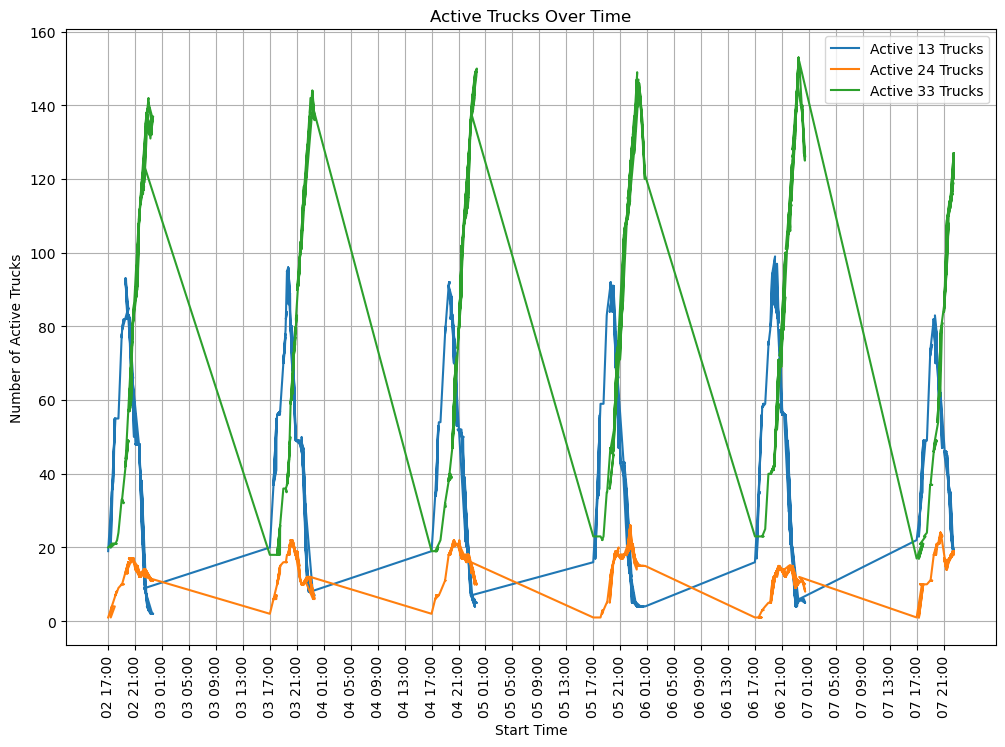

In [17]:
import matplotlib.pyplot as plt

#function to plot the active trucks over time of any plan
def plotTrucks(plan):
  name = [var for var, value in locals().items() if value is plan][0]
  # Plotting
  plt.figure(figsize=(12, 8))
  plt.plot(plan['start_time'], plan['active_13trucks'], linestyle='-', label='Active 13 Trucks') #make the line for the 13 capacity trucks
  plt.plot(plan['start_time'], plan['active_24trucks'], linestyle='-', label='Active 24 Trucks') #make the line for the 24 capacity trucks
  plt.plot(plan['start_time'], plan['active_33trucks'], linestyle='-', label='Active 33 Trucks') #make the line for the 33 capacity trucks

  plt.title('Active Trucks Over Time') #add the title
  plt.xlabel('Start Time') # add the x-label
  plt.ylabel('Number of Active Trucks') #add the y-label
  plt.legend() #show a legend
  plt.grid(True) #make a grid show

  
  # Create an hourly datetime range from the first to the last datetime
  hourly_range = pd.date_range(plan['start_time'].min(), plan['start_time'].max(), freq='4H') #make a nice scale for the x-axis so it's more readable
  plt.xticks(hourly_range, hourly_range.strftime('%d %H:00'), rotation=90) #set the axis to the scale

  plt.show()



plotTrucks(MixingPlan1driver) #run the plotting function with the desired plan

In [18]:
#need to find an optimal fleet size, right now we use max fleet size which means we pay a daily fixed price for each vehicle even if we don't use all vehicles that day
#we can reduce the fleet size but then whenever active trucks exceeds it's respective fleet size. For any extra vehicles, all costs must be increased by +30%
#e.g. fleet size for size 24 is 20, and we use 21, for 1 truck we have to pay fuel, driver and vehicle cost + 30% 
def getFleetAdjustedCosts(plan, f1, f2, f3):
    #make each fleet size a fraction of the maximum active trucks value
    fleet_size_13 = round(plan['active_13trucks'].max() * f1)
    fleet_size_24 = round(plan['active_24trucks'].max() * f2)
    fleet_size_33 = round(plan['active_33trucks'].max() * f3)


    # Fleet cost without 30% increase
    base_vehicle_cost = (fleet_size_13 * 95 + fleet_size_24 * 110 + fleet_size_33 * 110) * len(delivery_days)
    additional_fleet_cost = 0
    #make a loop, it repeats everything separately for each day 
    for day in delivery_days:        
        day = pd.to_datetime(day + " 2023") 
        # Filter the DataFrame to select rows where 'day' matches the desired delivery day
        day_plan = plan[plan['day'] == day].copy()

        # Calculate the additional cost for exceeding the fleet size with 30% increase
        additional_fleet_cost += 1.3 * (max(0, day_plan['active_13trucks'].max() - fleet_size_13)) * 95
        additional_fleet_cost += 1.3 * (max(0, day_plan['active_24trucks'].max() - fleet_size_24)) * 110 
        additional_fleet_cost += 1.3 * (max(0, day_plan['active_33trucks'].max() - fleet_size_33)) * 110 

    #total fuel cost is the sum of the fuel cost of each trip
    base_fuel_costs = plan['Fuel_cost'].sum()
    excess13 = plan[plan['active_13trucks'] > fleet_size_13]
    additional_fuel_cost = excess13[excess13['v_capacity'] == 13]['Fuel_cost'].sum() * 0.3

    excess24 = plan[plan['active_24trucks'] > fleet_size_24]
    additional_fuel_cost += excess24[excess24['v_capacity'] == 24]['Fuel_cost'].sum() * 0.3

    excess33 = plan[plan['active_33trucks'] > fleet_size_33]
    additional_fuel_cost += excess33[excess33['v_capacity'] == 33]['Fuel_cost'].sum() * 0.3


    #total driver cost is the sum of the driver cost of each trip
    base_driver_costs = plan['Driver_cost'].sum()
    excess13 = plan[plan['active_13trucks'] > fleet_size_13]
    additional_driver_cost = excess13[excess13['v_capacity'] == 13]['Driver_cost'].sum() * 0.3

    excess24 = plan[plan['active_24trucks'] > fleet_size_24]
    additional_driver_cost += excess24[excess24['v_capacity'] == 24]['Driver_cost'].sum() * 0.3

    excess33 = plan[plan['active_33trucks'] > fleet_size_33]
    additional_driver_cost += excess33[excess33['v_capacity'] == 33]['Driver_cost'].sum() * 0.3

    #total costs is the sum of all costs for that plan 
    total_costs = base_vehicle_cost + base_fuel_costs + base_driver_costs + additional_fleet_cost + additional_fuel_cost + additional_driver_cost
    #print(additional_fleet_cost, additional_fuel_cost, additional_driver_cost)
    return [fleet_size_13, fleet_size_24, fleet_size_33, total_costs]

fleets = pd.DataFrame(columns=["f13", "f24", "f33", "costs"])
index = 0
for n in range(0,110,10):
    for m in range(0,110,10):
        for o in range(0,110,10):
            # Create a new DataFrame row with the specified index and data
            data = getFleetAdjustedCosts(MixingPlan1driver, n/100, m/100, o/100)
            new_row = pd.DataFrame(data={"f13":data[0],"f24":data[1],"f33":data[2],"costs":data[3]}, index = [index])
            index += 1
            fleets = pd.concat([fleets, new_row])            

In [19]:
fleets

,f13,f24,f33,costs
0,0,0,0,571441.316333
1,0,0,15,568471.316333
2,0,0,31,560394.032333
3,0,0,46,552918.461000
4,0,0,61,546636.629333
...,...,...,...,...
1326,99,26,92,493091.782000
1327,99,26,107,481550.325667
1328,99,26,122,468776.209667
1329,99,26,138,455218.710667


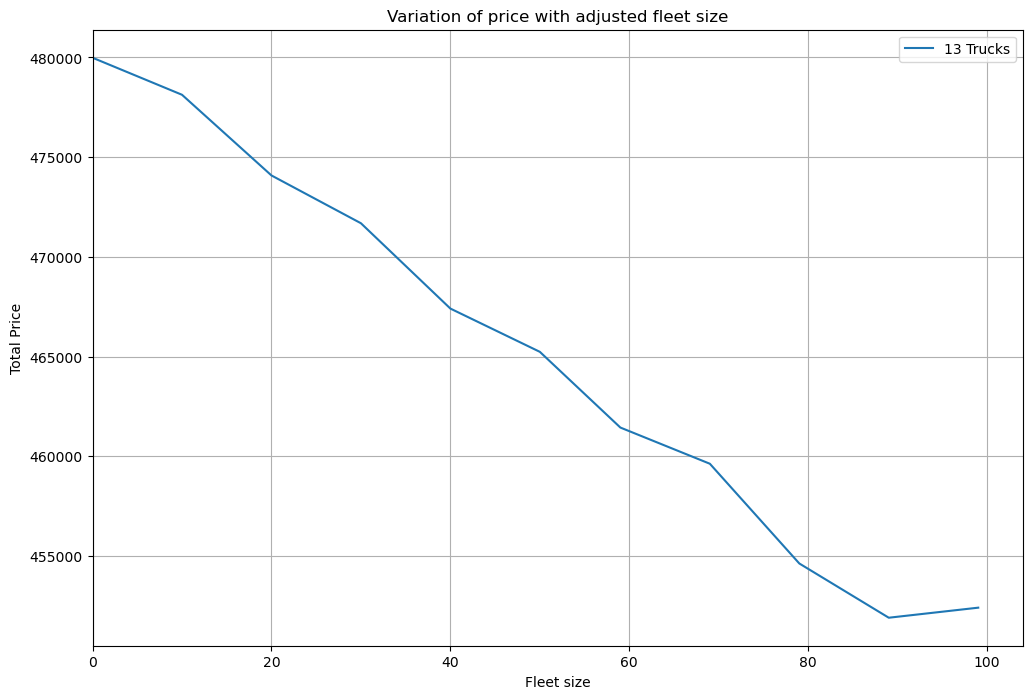

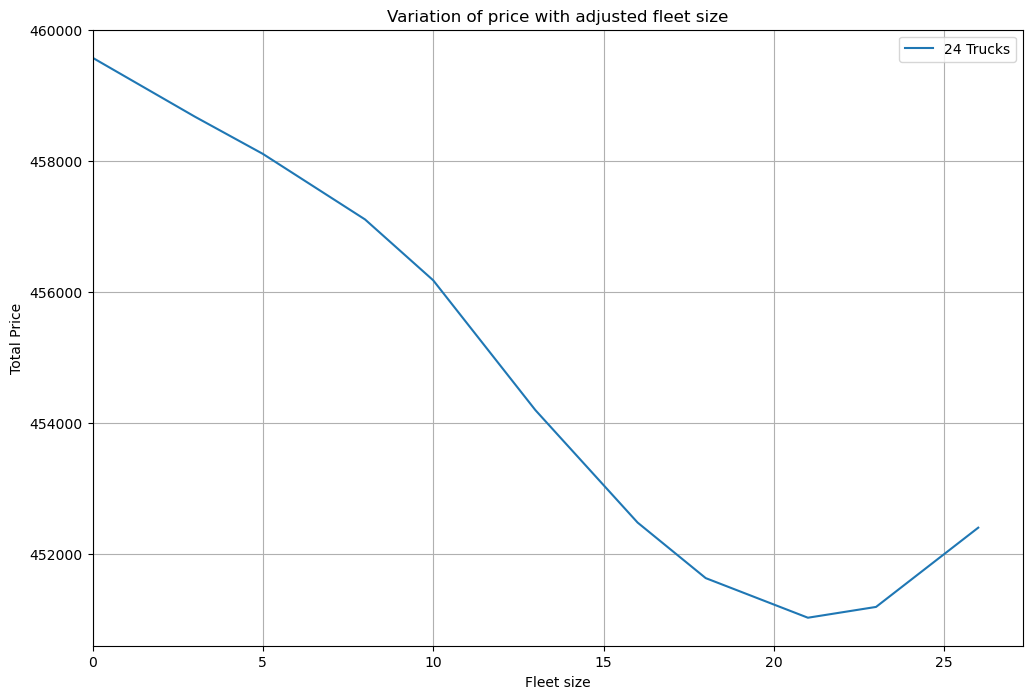

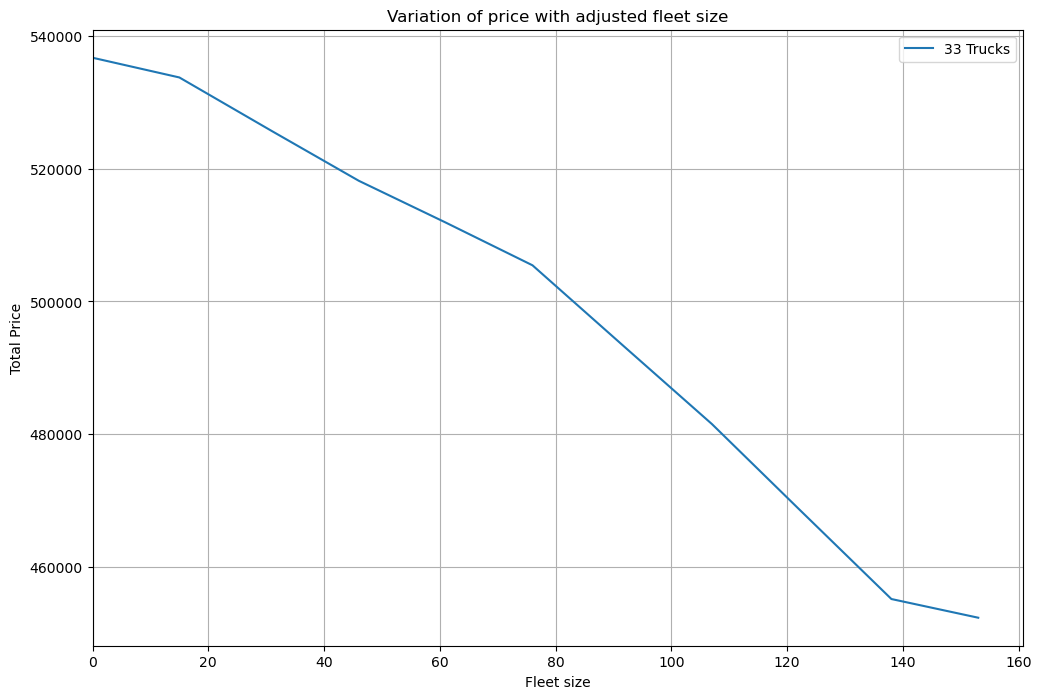

In [20]:
# Plotting how changing the fleet size impacts price

fleets13 = fleets[fleets['f24'] == 26]
fleets13 = fleets13[fleets13['f33'] == 153]

fleets24 = fleets[fleets['f13'] == 99]
fleets24 = fleets24[fleets24['f33'] == 153]

fleets33 = fleets[fleets['f24'] == 26]
fleets33 = fleets33[fleets33['f13'] == 99]

plt.figure(figsize=(12, 8))
plt.plot(fleets13['f13'], fleets13['costs'], linestyle='-', label='13 Trucks')

plt.title('Variation of price with adjusted fleet size')
plt.xlabel('Fleet size')
plt.ylabel('Total Price')
plt.legend()
plt.grid(True)

# Set minimum x and y values
plt.xlim(left=0)
# plt.ylim(bottom=0)

plt.show()

plt.figure(figsize=(12, 8))
plt.plot(fleets24['f24'], fleets24['costs'], linestyle='-', label='24 Trucks')

plt.title('Variation of price with adjusted fleet size')
plt.xlabel('Fleet size')
plt.ylabel('Total Price')
plt.legend()
plt.grid(True)

# Set minimum x and y values
plt.xlim(left=0)
# plt.ylim(bottom=0)

plt.show()

plt.figure(figsize=(12, 8))
plt.plot(fleets33['f33'], fleets33['costs'], linestyle='-', label='33 Trucks')

plt.title('Variation of price with adjusted fleet size')
plt.xlabel('Fleet size')
plt.ylabel('Total Price')
plt.legend()
plt.grid(True)

# Set minimum x and y values
plt.xlim(left=0)
# plt.ylim(bottom=0)

plt.show()

In [64]:
#Finding how many fresh and dry orders need to be delivered each day to group 7

all_G7_orders = all_orders[all_orders["Group"] == 7] #filter the oder list to only group 7
all_limited_G7_orders = all_G7_orders[all_G7_orders["Vehicle size limit"] != 33] # select all orders with a smaller vehicle
all_13_limited_G7_orders = all_G7_orders[all_G7_orders["Vehicle size limit"] == 13] # select all orders with a 13 limit
all_24_limited_G7_orders = all_G7_orders[all_G7_orders["Vehicle size limit"] == 24] # select all orders with a 24 limit

max_drylimit = 0 #set value of the maximium number of pallets of all days
max_freshlimit = 0 #set value of the maximium number of pallets of all days
max_13drylimit = 0 #set value of the maximium number of pallets of all days
max_13freshlimit = 0 #set value of the maximium number of pallets of all days
max_24drylimit = 0 #set value of the maximium number of pallets of all days
max_24freshlimit = 0 #set value of the maximium number of pallets of all days
for day in delivery_days: #check through each day and find the maximium for each value of the day
    print(day)
    day_limited_G7_orders = all_limited_G7_orders[all_limited_G7_orders["delivery date (d+1)"] == day]
    day_13_limited_G7_orders = all_13_limited_G7_orders[all_13_limited_G7_orders["delivery date (d+1)"] == day]
    day_24_limited_G7_orders = all_24_limited_G7_orders[all_24_limited_G7_orders["delivery date (d+1)"] == day]

    max_drylimit = max(max_drylimit, day_limited_G7_orders[day_limited_G7_orders["type"]=="DRY GOODS"]["pallets"].sum())
    max_freshlimit = max(max_freshlimit, day_limited_G7_orders[day_limited_G7_orders["type"]=="FRESH GOODS"]["pallets"].sum())

    max_13drylimit = max(max_13drylimit, day_13_limited_G7_orders[day_13_limited_G7_orders["type"]=="DRY GOODS"]["pallets"].sum())
    max_13freshlimit = max(max_13freshlimit, day_13_limited_G7_orders[day_13_limited_G7_orders["type"]=="FRESH GOODS"]["pallets"].sum())
    max_24drylimit = max(max_24drylimit, day_24_limited_G7_orders[day_24_limited_G7_orders["type"]=="DRY GOODS"]["pallets"].sum())
    max_24freshlimit = max(max_24freshlimit, day_24_limited_G7_orders[day_24_limited_G7_orders["type"]=="FRESH GOODS"]["pallets"].sum())
    
    print("Dry demand:", day_limited_G7_orders[day_limited_G7_orders["type"]=="DRY GOODS"]["pallets"].sum())
    print("13 limit:", day_13_limited_G7_orders[day_13_limited_G7_orders["type"]=="DRY GOODS"]["pallets"].sum())
    print("24 limit:", day_24_limited_G7_orders[day_24_limited_G7_orders["type"]=="DRY GOODS"]["pallets"].sum())
          
    print("Fresh demand:", day_limited_G7_orders[day_limited_G7_orders["type"]=="FRESH GOODS"]["pallets"].sum())
    print("13 limit:", day_13_limited_G7_orders[day_13_limited_G7_orders["type"]=="FRESH GOODS"]["pallets"].sum())
    print("24 limit:", day_24_limited_G7_orders[day_24_limited_G7_orders["type"]=="FRESH GOODS"]["pallets"].sum())      


02/may
Dry demand: 824
13 limit: 574
24 limit: 250
Fresh demand: 600
13 limit: 453
24 limit: 147
03/may
Dry demand: 900
13 limit: 689
24 limit: 211
Fresh demand: 577
13 limit: 440
24 limit: 137
04/may
Dry demand: 867
13 limit: 649
24 limit: 218
Fresh demand: 687
13 limit: 529
24 limit: 158
05/may
Dry demand: 942
13 limit: 647
24 limit: 295
Fresh demand: 613
13 limit: 436
24 limit: 177
06/may
Dry demand: 884
13 limit: 662
24 limit: 222
Fresh demand: 697
13 limit: 518
24 limit: 179
07/may
Dry demand: 781
13 limit: 570
24 limit: 211
Fresh demand: 646
13 limit: 481
24 limit: 165


In [65]:
print(max_drylimit)
print(max_freshlimit)
print(max_13drylimit)
print(max_13freshlimit)
print(max_24drylimit)
print(max_24freshlimit)

942
697
689
529
295
179
